In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import random
import scipy.integrate as integrate
import scipy.stats as stats
import torch
import time
import pandas as pd

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

/nfs/scistore14/vogelgrp/awilson/miniconda3/envs/sbi_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# SBI: target firing rate for dIN/cIN/MN = 20Hz; for aINs = 10Hz
# parameters to find: delta_g_ex, tau_ex for exc connections: 
# MN -> MN/dIN/aIN/cIN; dIN -> MN/dIN/aIN/cIN
# delta_g_inh, tau_inh for inh connections:
# aIN -> MN/dIN/aIN/cIN; cIN -> MN/dIN/aIN/cIN
# external current I ?? may be different for dINs and rest
# try with time constants being same for all exc/inh connections i.e. just find 1 tau_ex and 1 tau_inh
# gap juntion conductance

In [3]:
columns = ['Time (s)', 'Voltage (mV)']
PATH = "/nfs/scistore14/vogelgrp/awilson/tadpoleAdEx"

mn_filename = f'{PATH}/data/motoneuron_1429_f5.txt'
mn_df = pd.read_csv(mn_filename,header=None,names=columns,skiprows=0,delim_whitespace=True)
# mn_trace = mn_df['Voltage (mV)'].values.tolist()[:5000]
mn_trace = mn_df['Voltage (mV)'].values.tolist()
ain_filename = f'{PATH}/data/aIN_1311_f109.txt'
ain_df = pd.read_csv(ain_filename,header=None,names=columns,skiprows=0,delim_whitespace=True)
# ain_trace = ain_df['Voltage (mV)'].values.tolist()[:5000]
ain_trace = ain_df['Voltage (mV)'].values.tolist()
# cin_filename = f'{PATH}/data/cIN_v120_f4.txt' # we found cin with 18Hz below
cin_filename = f'{PATH}/data/cIN_v134_f10.txt'
cin_df = pd.read_csv(cin_filename,header=None,names=columns,skiprows=0,delim_whitespace=True)
# cin_trace_int = cin_df['Voltage (mV)'].values.tolist()[:5000]
cin_trace_int = cin_df['Voltage (mV)'].values.tolist()
cin_trace = [i*100 for i in cin_trace_int]
din_filename = f'{PATH}/data/dIN_1399_f12.txt'
din_df = pd.read_csv(din_filename,header=None,names=columns,skiprows=0,delim_whitespace=True)
# din_trace = din_df['Voltage (mV)'].values.tolist()[:5000]
din_trace = din_df['Voltage (mV)'].values.tolist()

In [ ]:
# the data is starting at different times, and we don't know if the zero of one dataframe is the same zero of the other, and it is 
# critical that the network dynamics are logical wrt neuron types

# one solution is just to ask the person who collected the data
# and otherwise just shift the timeseries according to alexia's knowledge


In [14]:
## EDA ##

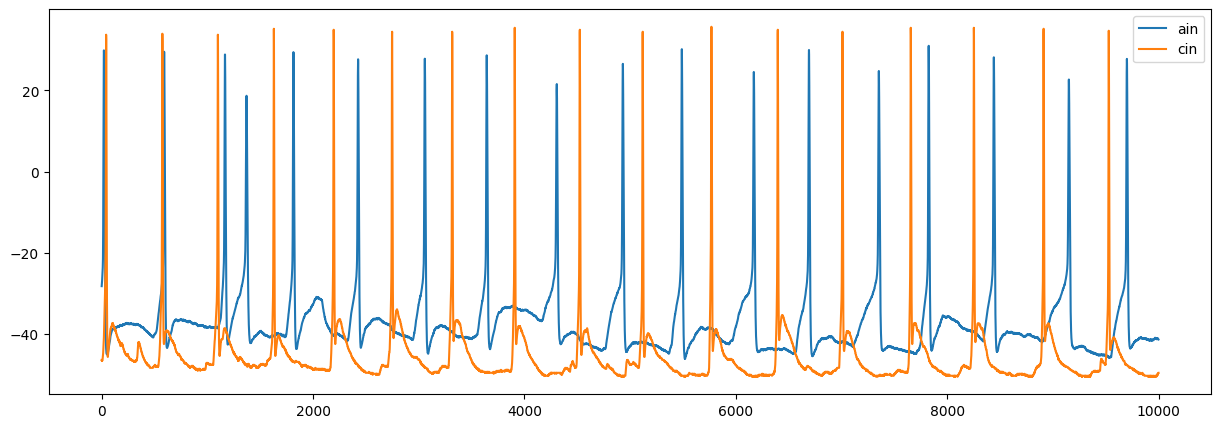

In [42]:
# time step is 0.1 ms
interval = 10000
xgrid = np.linspace(0, interval, num=interval)
start_mn = 9081
start_ain = 0
start_cin = 0
start_din = 0

# mn, ain, cin, din
windows = [(start_mn, start_mn + interval), (start_ain, start_ain + interval), (start_cin, start_cin + interval), (start_din, start_din + interval)]

plt.figure(figsize=(15, 5))
# plt.plot(xgrid, mn_df["Voltage (mV)"][windows[0][0]:windows[0][1]], label='mn')
plt.plot(xgrid, ain_df["Voltage (mV)"][windows[1][0]:windows[1][1]], label='ain')
plt.plot(xgrid, cin_df["Voltage (mV)"][windows[2][0]:windows[2][1]]*100, label='cin')
# plt.plot(xgrid, din_df["Voltage (mV)"][windows[3][0]:windows[3][1]], label='din')

plt.legend()

In [8]:
def run_AdEx_model(params):
    # run simulation: right side starts with slightly greater input than left side (first 25ms) so activity 
    # starts on that side
    time = 5000
    delta_t = 0.1
    V_thr = 0

    din_b = 0
    din_a = 12
    din_tau_w = 30
    din_cm = 200

    cm = 200
    g_L = 10
    E_L = -70
    E_ex = 0
    E_inh = -70
    g_ex = 0
    g_inh = 0
    V_T = -50
    V_thr = 0
    V_reset = -58
    mn_b = 60
    mn_a = 0
    mn_tau_w = 30

    slope_f = 2
    n_mns = 2
    n_ains = 2
    n_cins = 2
    n_dins = 2
        
    n_dins = 2
    n_mns = 2
    n_cins = 2
    n_ains = 2
            
#     delta_g_ex_mn_mn = float(params[0])
#     delta_g_ex_mn_ain = float(params[1])
#     delta_g_ex_mn_cin = float(params[2])
#     delta_g_ex_mn_din = float(params[3])
#     delta_g_ex_din_mn = float(params[4])
#     delta_g_ex_din_ain = float(params[5])
#     delta_g_ex_din_cin = float(params[6])
#     delta_g_ex_din_din = float(params[7])
#     delta_g_inh_ain_mn = float(params[8])
#     delta_g_inh_ain_ain = float(params[9])
#     delta_g_inh_ain_cin = float(params[10])
#     delta_g_inh_ain_din = float(params[11])
#     delta_g_inh_cin_mn = float(params[12])
#     delta_g_inh_cin_ain = float(params[13])
#     delta_g_inh_cin_cin = float(params[14])
#     delta_g_inh_cin_din = float(params[15])
#     tau_ex = float(params[16])
#     tau_inh = float(params[17])
#     g_gj = float(params[18])
    
    delta_g_ex = float(params[0])
    delta_g_inh = float(params[1])
    tau_ex = float(params[2])
    tau_inh = float(params[3])
    g_gj = float(params[4])
    
   # Voltage vector: size = number of MNs x 1; stored voltage matrix: size = number of recorded neurons x number of time steps. 
    n_record = 2
    n_timesteps = len(np.arange(0,time,delta_t))
    mn_voltage_vec = np.zeros((n_mns,1))
    mn_voltage_vec[:,:] += E_L
    mn_voltage_record = np.zeros((n_record,n_timesteps))
    # aINs
    ain_voltage_vec = np.zeros((n_ains,1))
    ain_voltage_vec[:,:] += E_L
    ain_voltage_record = np.zeros((n_record,n_timesteps))
    # cINs
    cin_voltage_vec = np.zeros((n_cins,1))
    cin_voltage_vec[:,:] += E_L
    cin_voltage_record = np.zeros((n_record,n_timesteps))
    # dINs
    din_voltage_vec = np.zeros((n_dins,1))
    din_voltage_vec[:,:] += E_L
    din_voltage_record = np.zeros((n_record,n_timesteps))
    din_current_record = np.zeros((n_record,n_timesteps))

    # Spike times list of lists: number of lists = number of MNs. 
    mn_spike_times = [[] for m in range(n_mns)]
    ain_spike_times = [[] for m in range(n_ains)]
    cin_spike_times = [[] for m in range(n_cins)]
    din_spike_times = [[] for m in range(n_dins)]

    # dIN gap junctions
    gap_junctions = np.zeros((n_dins,n_dins))
    for r in range(n_dins):
        for c in range(n_dins):
            if r < n_dins/2 and c < n_dins/2 or r >= n_dins/2 and c >= n_dins/2:
                if abs(r-c) < 4 and r != c:
                    gap_junctions[r,c] += 1

    # MN -> MN synapses.
    mn_synapses = np.zeros((n_mns,n_mns))
    for r in range(n_mns):
        for c in range(n_mns):
            if r < n_mns/2 and c < n_mns/2 or r >= n_mns/2 and c >= n_mns/2:
                if random.random() < 0.05 and r != c:
                    mn_synapses[r,c] += 1

    # MN -> dIN synapses.
    mn_din_synapses = np.zeros((n_mns,n_dins))
    for r in range(n_mns):
        for c in range(n_dins):
            if r < n_mns/2 and c < n_dins/2 or r >= n_mns/2 and c >= n_dins/2:
                if random.random() < 0.05 and r != c:
                    mn_din_synapses[r,c] += 1

    # MN -> aIN synapses.
    mn_ain_synapses = np.zeros((n_mns,n_ains))
    for r in range(n_mns):
        for c in range(n_ains):
            if r < n_mns/2 and c < n_ains/2 or r >= n_mns/2 and c >= n_ains/2:
                if random.random() < 0.05 and r != c:
                    mn_ain_synapses[r,c] += 1

    # MN -> cIN synapses.
    mn_cin_synapses = np.zeros((n_mns,n_cins))
    for r in range(n_mns):
        for c in range(n_cins):
            if r < n_mns/2 and c < n_cins/2 or r >= n_mns/2 and c >= n_cins/2:
                if random.random() < 0.05 and r != c:
                    mn_cin_synapses[r,c] += 1   

    # aIN -> MN synapses.
    ain_mn_synapses = np.zeros((n_ains,n_mns))
    for r in range(n_ains):
        for c in range(n_mns):
            if r < n_ains/2 and c < n_mns/2 or r >= n_ains/2 and c >= n_mns/2:
                if random.random() < 0.1:
                    ain_mn_synapses[r,c] += 1

    # aIN -> aIN synapses.
    ain_synapses = np.zeros((n_ains,n_ains))
    for r in range(n_ains):
        for c in range(n_ains):
            if r < n_ains/2 and c < n_ains/2 or r >= n_ains/2 and c >= n_ains/2:
                if random.random() < 0.1 and r != c:
                    ain_synapses[r,c] += 1

    # aIN -> cIN synapses.
    ain_cin_synapses = np.zeros((n_ains,n_cins))
    for r in range(n_ains):
        for c in range(n_cins):
            if r < n_ains/2 and c < n_cins/2 or r >= n_ains/2 and c >= n_cins/2:
                if random.random() < 0.1:
                    ain_cin_synapses[r,c] += 1

    # aIN -> dIN synapses.
    ain_din_synapses = np.zeros((n_ains,n_dins))
    for r in range(n_ains):
        for c in range(n_dins):
            if r < n_ains/2 and c < n_dins/2 or r >= n_ains/2 and c >= n_dins/2:
                if random.random() < 0.1:
                    ain_din_synapses[r,c] += 1

    # cIN -> aIN synapses.
    cin_ain_synapses = np.zeros((n_cins,n_ains))
    for r in range(n_cins):
        for c in range(n_ains):
            if r < n_cins/2 and c >= n_ains/2 or r >= n_cins/2 and c < n_ains/2:
                if random.random() < 0.1:
                    cin_ain_synapses[r,c] += 1

    # cIN -> MN synapses.
    cin_mn_synapses = np.zeros((n_cins,n_mns))
    for r in range(n_cins):
        for c in range(n_mns):
            if r < n_cins/2 and c >= n_mns/2 or r >= n_cins/2 and c < n_mns/2:
                if random.random() < 0.1:
                    cin_mn_synapses[r,c] += 1

    # cIN -> cIN synapses.
    cin_synapses = np.zeros((n_cins,n_cins))
    for r in range(n_cins):
        for c in range(n_cins):
            if r < n_cins/2 and c >= n_cins/2 or r >= n_cins/2 and c < n_cins/2:
                if random.random() < 0.1:
                    cin_synapses[r,c] += 1

    # cIN -> dIN synapses.
    cin_din_synapses = np.zeros((n_cins,n_dins))
    for r in range(n_cins):
        for c in range(n_dins):
            if r < n_cins/2 and c >= n_dins/2 or r >= n_cins/2 and c < n_dins/2:
                if random.random() < 0.1:
                    cin_din_synapses[r,c] += 1

    # dIN -> dIN synapses.
    din_synapses = np.zeros((n_dins,n_dins))
    for r in range(n_dins):
        for c in range(n_dins):
            if r < n_dins/2 and c < n_dins/2 or r >= n_dins/2 and c >= n_dins/2:
                if random.random() < 0.1 and r != c:
                    din_synapses[r,c] += 1   

    # dIN -> MN synapses.
    din_mn_synapses = np.zeros((n_dins,n_mns))
    for r in range(n_dins):
        for c in range(n_mns):
            if r < n_dins/2 and c < n_mns/2 or r >= n_dins/2 and c >= n_mns/2:
                if random.random() < 0.1:
                    din_mn_synapses[r,c] += 1

    # dIN -> aIN synapses.
    din_ain_synapses = np.zeros((n_dins,n_ains))
    for r in range(n_dins):
        for c in range(n_ains):
            if r < n_dins/2 and c < n_ains/2 or r >= n_dins/2 and c >= n_ains/2:
                if random.random() < 0.1:
                    din_ain_synapses[r,c] += 1

    # dIN -> cIN synapses.
    din_cin_synapses = np.zeros((n_dins,n_cins))
    for r in range(n_dins):
        for c in range(n_cins):
            if r < n_dins/2 and c < n_cins/2 or r >= n_dins/2 and c >= n_cins/2:
                if random.random() < 0.1:
                    din_cin_synapses[r,c] += 1

    mn_g_ex = np.zeros((n_mns,1))
    mn_g_inh = np.zeros((n_mns,1))
    mn_w = np.zeros((n_mns,1))
    ain_g_ex = np.zeros((n_ains,1))
    ain_g_inh = np.zeros((n_ains,1))
    ain_w = np.zeros((n_ains,1))
    cin_g_ex = np.zeros((n_cins,1))
    cin_g_inh = np.zeros((n_cins,1))
    cin_w = np.zeros((n_cins,1))
    din_g_ex = np.zeros((n_dins,1))
    din_g_inh = np.zeros((n_dins,1))
    din_w = np.zeros((n_dins,1))
    din_ws = []

    
    for idx,t in enumerate(np.arange(0,time,delta_t)):
        if t > 25:
            I_L = 200
            I_R = 200
            I_L_din = 400
            I_R_din = 400
        else:
            I_L = 150
            I_R = 200
            I_L_din = 350
            I_R_din = 400
        i_gj = np.zeros((1,n_dins))
        for mn in range(n_mns):
            if mn_voltage_vec[mn,-1] >= V_thr:
                mn_voltage_vec[mn,-1] = V_reset
        for ain in range(n_ains):
            if ain_voltage_vec[ain,-1] >= V_thr:
                ain_voltage_vec[ain,-1] = V_reset
        for cin in range(n_cins):
            if cin_voltage_vec[cin,-1] >= V_thr:
                cin_voltage_vec[cin,-1] = V_reset
        for din in range(n_dins):
            if din_voltage_vec[din,-1] >= V_thr:
                din_voltage_vec[din,-1] = V_reset
        # dIN gap junctions
        for row in range(n_dins):
            for c in range(n_dins):
                i_gj[:,row] += gap_junctions[row,c]*(din_voltage_vec[row,-1] - din_voltage_vec[c,-1])*g_gj
        i_gj = i_gj.reshape(n_dins,1)
        i_gj = np.zeros((n_dins,1))
        # AMPA synapses from MNs to CPG
        for mn in range(n_mns):
            spikes = mn_spike_times[mn]
            for spike in spikes:
                if spike + 1 == t:
                    mn_g_ex += mn_synapses[mn,-1]*delta_g_ex #delta_g_ex_mn_mn
                    din_g_ex += mn_din_synapses[mn, -1]*delta_g_ex #delta_g_ex_mn_din
                    ain_g_ex += mn_ain_synapses[mn, -1]*delta_g_ex #delta_g_ex_mn_ain
                    cin_g_ex += mn_cin_synapses[mn, -1]*delta_g_ex #delta_g_ex_mn_cin
#       dIN -> MN/aIN/cIN/dIN excitatory synapses
        for din in range(n_dins):
            spikes = din_spike_times[din]
            for spike in spikes:
                if spike + 1 == t:
                    din_g_ex += din_synapses[din,-1]*delta_g_ex #delta_g_ex_din_din
                    mn_g_ex += din_mn_synapses[din,-1]*delta_g_ex #delta_g_ex_din_mn
                    ain_g_ex += din_ain_synapses[din,-1]*delta_g_ex #delta_g_ex_din_ain
                    cin_g_ex += din_cin_synapses[din,-1]*delta_g_ex #delta_g_ex_din_cin
        # aIN -> MN/aIN/cIN/dIN inhibitory synapses
        for ain in range(n_ains):
            spikes = ain_spike_times[ain]
            for spike in spikes:
                if spike + 1 == t:
                    mn_g_inh += ain_mn_synapses[ain,-1]*delta_g_inh #delta_g_inh_ain_mn
                    ain_g_inh += ain_synapses[ain,-1]*delta_g_inh #delta_g_inh_ain_ain
                    cin_g_inh += ain_cin_synapses[ain,-1]*delta_g_inh #delta_g_inh_ain_cin
                    din_g_inh += ain_din_synapses[ain,-1]*delta_g_inh #delta_g_inh_ain_din
        # cIN -> aIN/MN/dIN/cIN synapses
        for cin in range(n_cins):
            spikes = cin_spike_times[cin]
            for spike in spikes:
                if spike + 1 == t:
                    mn_g_inh += cin_mn_synapses[cin,-1]*delta_g_inh #delta_g_inh_cin_mn
                    ain_g_inh += cin_ain_synapses[cin,-1]*delta_g_inh #delta_g_inh_cin_ain
                    cin_g_inh += cin_synapses[cin,-1]*delta_g_inh #delta_g_inh_cin_cin
                    din_g_inh += cin_din_synapses[cin,-1]*delta_g_inh #delta_g_inh_cin_din 
        mn_voltage_vec[:int(n_mns/2),-1] += delta_t*((-g_L*(mn_voltage_vec[:int(n_mns/2),-1] - E_L) + g_L * slope_f * np.exp((mn_voltage_vec[:int(n_mns/2),-1] - V_T)/slope_f) \
                                         - mn_g_ex[:int(n_mns/2),-1] * (mn_voltage_vec[:int(n_mns/2),-1] - E_ex) - mn_g_inh[:int(n_mns/2),-1] * (mn_voltage_vec[:int(n_mns/2),-1] \
                                         - E_inh) + I_L - mn_w[:int(n_mns/2),-1]) / cm)
        mn_voltage_vec[int(n_mns/2):,-1] += delta_t*((-g_L*(mn_voltage_vec[int(n_mns/2):,-1] - E_L) + g_L * slope_f * np.exp((mn_voltage_vec[int(n_mns/2):,-1] - V_T)/slope_f) \
                                         - mn_g_ex[int(n_mns/2):,-1] * (mn_voltage_vec[int(n_mns/2):,-1] - E_ex) - mn_g_inh[int(n_mns/2):,-1] * (mn_voltage_vec[int(n_mns/2):,-1] \
                                         - E_inh) + I_R - mn_w[int(n_mns/2):,-1]) / cm)
        ain_voltage_vec[:int(n_ains/2),-1] += delta_t*((-g_L*(ain_voltage_vec[:int(n_ains/2),-1] - E_L) + g_L * slope_f * np.exp((ain_voltage_vec[:int(n_ains/2),-1] - V_T)/slope_f) \
                                              - ain_g_ex[:int(n_ains/2),-1] * (ain_voltage_vec[:int(n_ains/2),-1] - E_ex) \
                                              - ain_g_inh[:int(n_ains/2),-1] * (ain_voltage_vec[:int(n_ains/2),-1] - E_inh) + I_L - ain_w[:int(n_ains/2),-1]) / cm)
        ain_voltage_vec[int(n_ains/2):,-1] += delta_t*((-g_L*(ain_voltage_vec[int(n_ains/2):,-1] - E_L) + g_L * slope_f * np.exp((ain_voltage_vec[int(n_ains/2):,-1] - V_T)/slope_f) \
                                              - ain_g_ex[int(n_ains/2):,-1] * (ain_voltage_vec[int(n_ains/2):,-1] - E_ex) \
                                              - ain_g_inh[int(n_ains/2):,-1] * (ain_voltage_vec[int(n_ains/2):,-1] - E_inh) + I_R - ain_w[int(n_ains/2):,-1]) / cm)
        cin_voltage_vec[:int(n_cins/2),-1] += delta_t*((-g_L*(cin_voltage_vec[:int(n_cins/2),-1] - E_L) + g_L * slope_f * np.exp((cin_voltage_vec[:int(n_cins/2),-1] - V_T)/slope_f) \
                                              - cin_g_ex[:int(n_cins/2),-1] * (cin_voltage_vec[:int(n_cins/2),-1] - E_ex) \
                                              - cin_g_inh[:int(n_cins/2),-1] * (cin_voltage_vec[:int(n_cins/2),-1] - E_inh) + I_L - cin_w[:int(n_cins/2),-1]) / cm)
        cin_voltage_vec[int(n_cins/2):,-1] += delta_t*((-g_L*(cin_voltage_vec[int(n_cins/2):,-1] - E_L) + g_L * slope_f * np.exp((cin_voltage_vec[int(n_cins/2):,-1] - V_T)/slope_f) \
                                              - cin_g_ex[int(n_cins/2):,-1] * (cin_voltage_vec[int(n_cins/2):,-1] - E_ex) \
                                              - cin_g_inh[int(n_cins/2):,-1] * (cin_voltage_vec[int(n_cins/2):,-1] - E_inh) + I_R - cin_w[int(n_cins/2):,-1]) / cm)
        din_voltage_vec[:int(n_dins/2),-1] += delta_t*((-g_L*(din_voltage_vec[:int(n_dins/2),-1] - E_L) + g_L * slope_f * np.exp((din_voltage_vec[:int(n_dins/2),-1] - V_T)/slope_f) \
                                              - din_g_ex[:int(n_dins/2),-1] * (din_voltage_vec[:int(n_dins/2),-1] - E_ex) \
                                              - din_g_inh[:int(n_dins/2),-1] * (din_voltage_vec[:int(n_dins/2),-1] - E_inh) - i_gj[:int(n_dins/2),-1] \
                                              + I_L_din - din_w[:int(n_dins/2),-1]) / din_cm)
        din_voltage_vec[int(n_dins/2):,-1] += delta_t*((-g_L*(din_voltage_vec[int(n_dins/2):,-1] - E_L) + g_L * slope_f * np.exp((din_voltage_vec[int(n_dins/2):,-1] - V_T)/slope_f) \
                                              - din_g_ex[int(n_dins/2):,-1] * (din_voltage_vec[int(n_dins/2):,-1] - E_ex) \
                                              - din_g_inh[int(n_dins/2):,-1] * (din_voltage_vec[int(n_dins/2):,-1] - E_inh) - i_gj[int(n_dins/2):,-1] \
                                              + I_R_din - din_w[int(n_dins/2):,-1]) / din_cm)
        din_current_record[0,idx] += - g_L*(din_voltage_vec[0,-1] - E_L) + g_L * slope_f * np.exp((din_voltage_vec[0,-1] - V_T)/slope_f) \
                                     - din_g_ex[0,-1] * (din_voltage_vec[0,-1] - E_ex) - din_g_inh[0,-1] * (din_voltage_vec[0,-1] - E_inh) - i_gj[0,-1] + I_R_din - din_w[0,-1]
        din_current_record[1,idx] += - g_L*(din_voltage_vec[int(n_dins/2),-1] - E_L) + g_L * slope_f * np.exp((din_voltage_vec[int(n_dins/2),-1] - V_T)/slope_f) \
                                     - din_g_ex[int(n_dins/2),-1] * (din_voltage_vec[int(n_dins/2),-1] - E_ex) \
                                     - din_g_inh[int(n_dins/2),-1] * (din_voltage_vec[int(n_dins/2),-1] - E_inh) - i_gj[int(n_dins/2),-1] + I_R_din - din_w[int(n_dins/2),-1]
        mn_w += delta_t*((mn_a * (mn_voltage_vec - E_L) - mn_w) / mn_tau_w)
        ain_w += delta_t*((mn_a * (ain_voltage_vec - E_L) - ain_w) / mn_tau_w)
        cin_w += delta_t*((mn_a * (cin_voltage_vec - E_L) - cin_w) / mn_tau_w)
        din_w += delta_t*((din_a * (din_voltage_vec - E_L) - din_w) / din_tau_w)
        din_ws.append(din_w[0,-1])
        mn_g_ex += delta_t*(-mn_g_ex/tau_ex)
        mn_g_inh += delta_t*(-mn_g_inh/tau_inh)
        ain_g_ex += delta_t*(-ain_g_ex/tau_ex)
        ain_g_inh += delta_t*(-ain_g_inh/tau_inh)
        cin_g_ex += delta_t*(-cin_g_ex/tau_ex)
        cin_g_inh += delta_t*(-cin_g_inh/tau_inh)
        din_g_ex += delta_t*(-din_g_ex/tau_ex)
        din_g_inh += delta_t*(-din_g_inh/tau_inh)
        for mn in range(n_mns):
            if mn_voltage_vec[mn,-1] >= V_thr:
                mn_voltage_vec[mn,-1] = V_thr
                mn_spike_times[mn].append(t)
                mn_w[mn,-1] += mn_b
        mn_voltage_record[:,idx] += mn_voltage_vec[[0,int(n_mns/2)],:].squeeze()
        for ain in range(n_ains):
            if ain_voltage_vec[ain,-1] >= V_thr:
                ain_voltage_vec[ain,-1] = V_thr
                ain_spike_times[ain].append(t)
                ain_w[ain,-1] += mn_b
        ain_voltage_record[:,idx] += ain_voltage_vec[[0,int(n_ains/2)],:].squeeze()
        for cin in range(n_cins):
            if cin_voltage_vec[cin,-1] >= V_thr:
                cin_voltage_vec[cin,-1] = V_thr
                cin_spike_times[cin].append(t)
                cin_w[cin,-1] += mn_b
        cin_voltage_record[:,idx] += cin_voltage_vec[[0,int(n_cins/2)],:].squeeze()
        for din in range(n_dins):
            if din_voltage_vec[din,-1] >= V_thr:
                din_voltage_vec[din,-1] = V_thr
                din_spike_times[din].append(t)
                din_w[din,-1] += din_b
        din_voltage_record[:,idx] += din_voltage_vec[[0,int(n_dins/2)],:].squeeze()
    
    return mn_voltage_record, ain_voltage_record, cin_voltage_record, din_voltage_record


def calculate_summary_statistics(mn_x, ain_x, cin_x, din_x):
# calculate the summary statistics: average firing rate and l-r phase difference for MNs, aINs, cINs and dINs
    time = 5000
    delta_t = 0.1
    V_thr = 0
    fr_mns = np.zeros(np.shape(mn_x)[0])
    time_spike1_mns = np.zeros(np.shape(mn_x)[0])
    fr_ains = np.zeros(np.shape(ain_x)[0])
    time_spike1_ains = np.zeros(np.shape(ain_x)[0])
    fr_cins = np.zeros(np.shape(cin_x)[0])
    time_spike1_cins = np.zeros(np.shape(cin_x)[0])
    fr_dins = np.zeros(np.shape(din_x)[0])
    time_spike1_dins = np.zeros(np.shape(din_x)[0])
    for mn in range(np.shape(mn_x)[0]):
        fr_mns[mn] += len(np.where(mn_x[mn,:] >= V_thr))/(time/1000)
        time_spike1_mns[mn] += np.where(mn_x[mn,:] >= V_thr)[0][0]*delta_t
    for ain in range(np.shape(ain_x)[0]):
        fr_ains[ain] += len(np.where(ain_x[ain,:] >= V_thr))/(time/1000)
        time_spike1_ains[ain] += np.where(ain_x[ain,:] >= V_thr)[0][0]*delta_t
    for cin in range(np.shape(cin_x)[0]):
        fr_cins[cin] += len(np.where(cin_x[cin,:] >= V_thr))/(time/1000)
        time_spike1_cins[cin] += np.where(cin_x[cin,:] >= V_thr)[0][0]*delta_t
    for din in range(np.shape(din_x)[0]):
        fr_dins[din] += len(np.where(din_x[din,:] >= V_thr))/(time/1000)
        time_spike1_dins[din] += np.where(din_x[din,:] >= V_thr)[0][0]*delta_t
    spike1_diff_mn = np.abs(time_spike1_mns[0] - time_spike1_mns[1])
    av_fr_mn = (fr_mns[0] + fr_mns[1]) / 2
    av_isi_mn = 1000 * (1 / av_fr_mn)
    phase_diff_mn = spike1_diff_mn / av_isi_mn
    spike1_diff_ain = np.abs(time_spike1_ains[0] - time_spike1_ains[1])
    av_fr_ain = (fr_ains[0] + fr_ains[1]) / 2
    av_isi_ain = 1000 * (1 / av_fr_ain)
    phase_diff_ain = spike1_diff_ain / av_isi_ain
    spike1_diff_cin = np.abs(time_spike1_cins[0] - time_spike1_cins[1])
    av_fr_cin = (fr_cins[0] + fr_cins[1]) / 2
    av_isi_cin = 1000 * (1 / av_fr_cin)
    phase_diff_cin = spike1_diff_cin / av_isi_cin
    spike1_diff_din = np.abs(time_spike1_dins[0] - time_spike1_dins[1])
    av_fr_din = (fr_dins[0] + fr_dins[1]) / 2
    av_isi_din = 1000 * (1 / av_fr_din)
    phase_diff_din = spike1_diff_din / av_isi_din
    sum_stats = np.array((av_fr_mn, phase_diff_mn, av_fr_ain, phase_diff_ain, av_fr_cin, phase_diff_cin, av_fr_din, phase_diff_din))
    return sum_stats

In [9]:
def simulation_wrapper(params):
    obs_mn, obs_ain, obs_cin, obs_din = run_AdEx_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs_mn, obs_ain, obs_cin, obs_din))
    return summstats  

In [10]:
num_sim = 500

# experimental parameters: firing rate for MNs, dINs, cINs = 20Hz while for aINs = 10Hz
# phase difference between left and right side for each population should be 0.5
exp_stats = np.array((20, 0.5, 10, 0.5, 20, 0.5, 20, 0.5))

# generate priors
# prior_min = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# prior_max = [50, 50, 50, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100, 100, 100, 100, 20, 10, 1]

prior_min = [10, 20, 2, 1, 0]
prior_max = [15, 40, 10, 6, 0.5]
prior =utils.torchutils.BoxUniform(
        low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [11]:
simulator, prior = prepare_for_sbi(simulation_wrapper,prior)
inference = SNPE(prior=prior)

/tmp/ipykernel_1427580/4144290213.py:335: RuntimeWarning: overflow encountered in exp
  din_current_record[1,idx] += - g_L*(din_voltage_vec[int(n_dins/2),-1] - E_L) + g_L * slope_f * np.exp((din_voltage_vec[int(n_dins/2),-1] - V_T)/slope_f) \
/tmp/ipykernel_1427580/4144290213.py:333: RuntimeWarning: overflow encountered in exp
  din_current_record[0,idx] += - g_L*(din_voltage_vec[0,-1] - E_L) + g_L * slope_f * np.exp((din_voltage_vec[0,-1] - V_T)/slope_f) \


In [12]:
# single round SBI
theta, x = simulate_for_sbi(simulator, prior, num_simulations=100, num_workers=4)
density_estimator = inference.append_simulations(theta,x,proposal=prior).train()
posterior = inference.build_posterior(density_estimator)
posterior_sample = posterior.sample((1,), x=exp_stats).numpy()

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:03<?, ?it/s]


TypeError: The only supported seed types are: None,
int, float, str, bytes, and bytearray.

In [ ]:
def plot_sample(posterior_sample, mn_obs, ain_obs, cin_obs, din_obs):
    time = 5000
    delta_t = 0.1
    # simulate and plot samples
    fig = plt.figure(figsize=(7, 5))
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")
    
    x_mn, x_ain, x_cin, x_din = run_AdEx_model(posterior_sample[0])
    plt.plot(np.arange(0,time,delta_t), mn_obs, lw=2, label="MN observation")
    plt.plot(np.arange(0,time,delta_t), ain_obs, lw=2, label="aIN observation")
    plt.plot(np.arange(0,time,delta_t), cin_obs, lw=2, label="cIN observation")
    plt.plot(np.arange(0,time,delta_t), din_obs, lw=2, label="dIN observation")
    plt.plot(np.arange(0,time,delta_t), x_mn, "--", lw=2, label="MN posterior sample")
    plt.plot(np.arange(0,time,delta_t), x_ain, "--", lw=2, label="aIN posterior sample")
    plt.plot(np.arange(0,time,delta_t), x_cin, "--", lw=2, label="cIN posterior sample")
    plt.plot(np.arange(0,time,delta_t), x_din, "--", lw=2, label="dIN posterior sample")
    
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    plt.savefig('Figures/SBI_CPG_500sims.png')
    
def pairplot(posterior, exp_stats):
    samples = posterior.sample((10000,), x=exp_stats)
    fig, axes = analysis.pairplot(
    samples,
    limits=[[0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 100], [0, 100], \
            [0, 100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 20], [0, 10], [0, 1]],
    ticks=[[0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 50], [0, 100], [0, 100], \
           [0, 100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 20], [0, 10], [0, 1]],
    figsize=(10, 10),
    #     points=exp_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    );

    plt.savefig('Figures/pairplot_CPG.png')

In [ ]:
plot_sample(posterior_sample, obs_mn, obs_ain, obs_cin, obs_din):